<a href="https://colab.research.google.com/github/wvirany/NNGP/blob/main/NNGP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

import warnings
warnings.filterwarnings('ignore')


sns.set_style({"axes.facecolor": "#f7f9fc",
               "axes.edgecolor": "#000000",
               "grid.color": "#EBEBE7",
               "font.family": "serif",
               "axes.labelcolor": "#000000",
               "xtick.color": "#000000",
               "ytick.color": "#000000",
               "grid.alpha": 0.4 })

np.random.seed(42)

In [2]:
def gaussian_activation(x, mean=0.0, sigma=1.0):
    return tf.exp(-tf.square(x - mean) / (2 * tf.square(sigma)))

In [3]:
class SingleLayerNetwork(keras.Model):

  def __init__(self, num_units, activation=tf.math.sin):

    super().__init__()

    self.net = Sequential([
        Dense(num_units, input_shape=(1,), activation=activation,
              kernel_initializer=RandomNormal(mean=0.0, stddev=1.0),
              bias_initializer=RandomNormal(mean=0.0, stddev=1.0)),
        Dense(1, activation='linear',
              kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(num_units)),
              bias_initializer=RandomNormal(mean=0.0, stddev=.1))
    ])


  def call(self, X):
    return self.net(X)


  def train_step(self, x_train, y_train, optimizer, loss_fn):
    """
    Performs one step of gradient descent

    Args:
        - x_train: Input data for training (features).
        - y_train: Ground truth values (targets)
    """

    with tf.GradientTape() as tape:

      output = self(x_train)

      loss = loss_fn(y_train, output)

    gradients = tape.gradient(loss, self.trainable_variables)

    optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    return loss

In [4]:
noise_scale = 0

f = lambda x: 5 * np.sin(x)

train_points = 5
noise_scale = 1e-1

In [5]:
x_train = np.random.uniform(-np.pi, np.pi, 5)
y_train = f(x_train)
y_train += noise_scale * np.random.normal(0, 1, 5)
train = (x_train, y_train)

x_test = np.linspace(-np.pi, np.pi, 50)

In [47]:
nn_ensemble = []

for i in range(50):

  model = SingleLayerNetwork(num_units=256)
  nn_ensemble.append(model)

In [48]:
nn_ensemble[0].summary()

Model: "single_layer_network_200"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_200 (Sequential)          │ (None, 1)                   │             769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

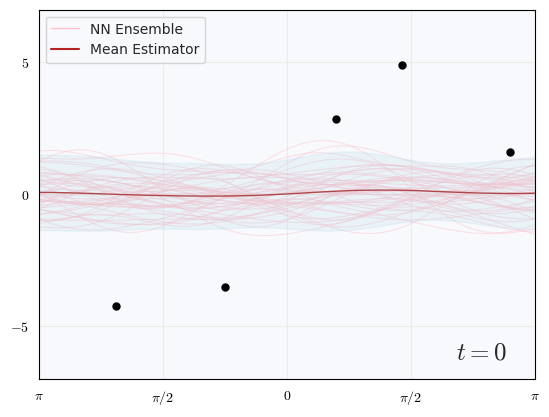

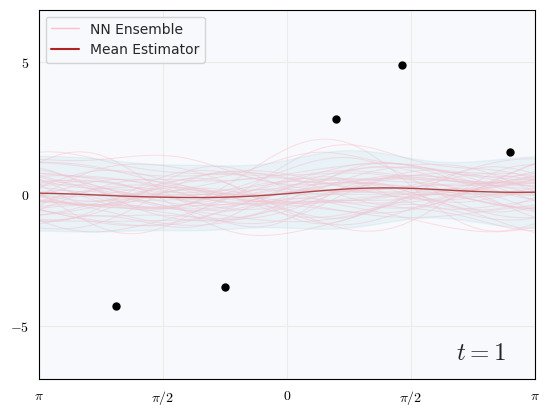

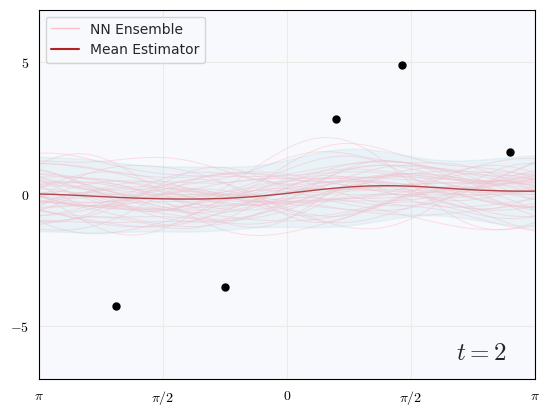

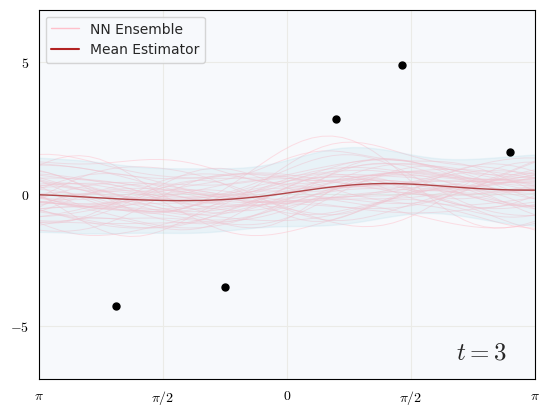

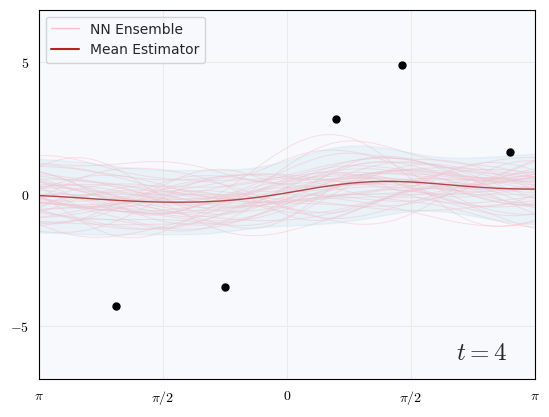

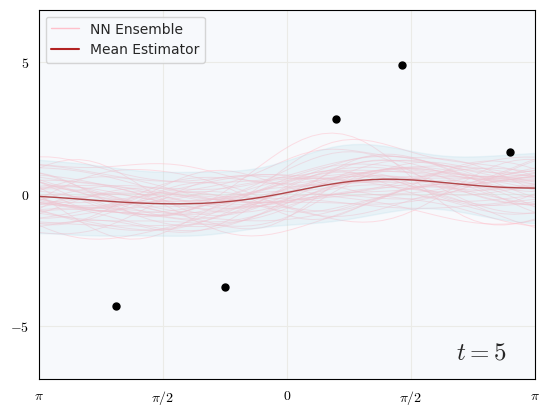

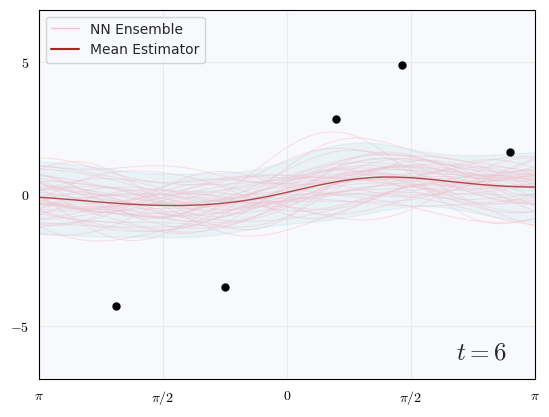

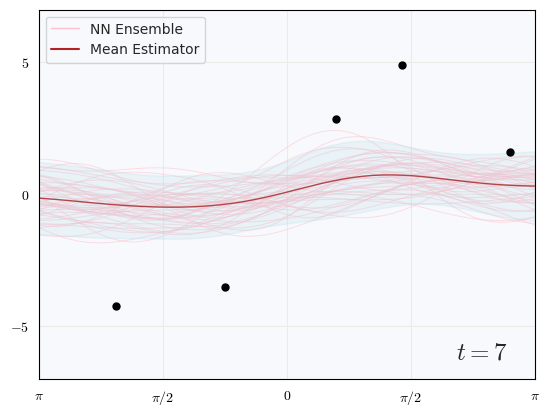

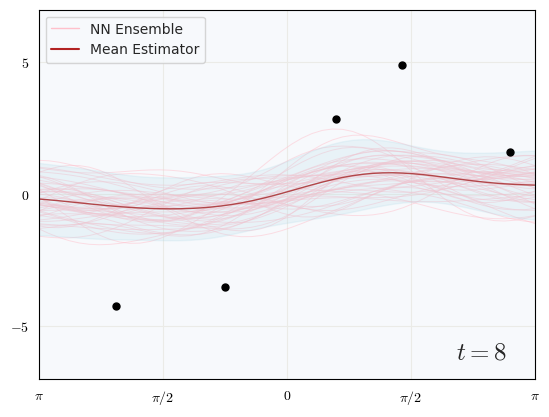

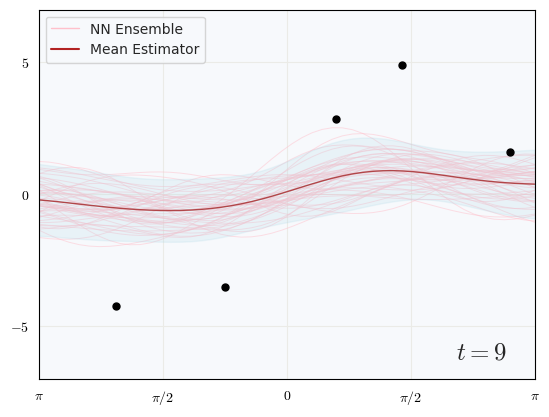

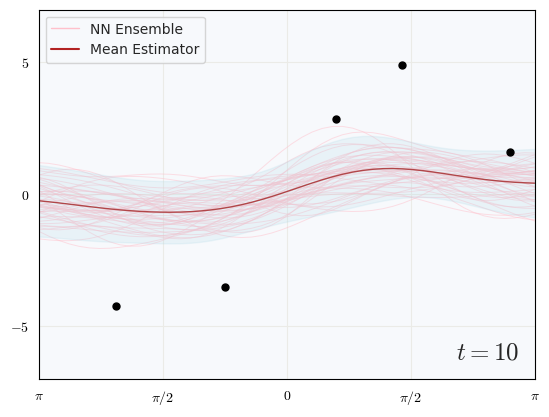

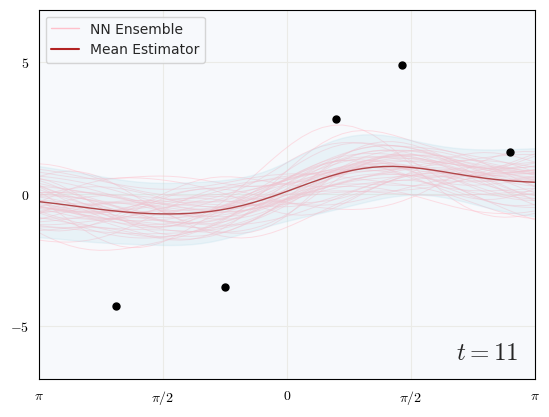

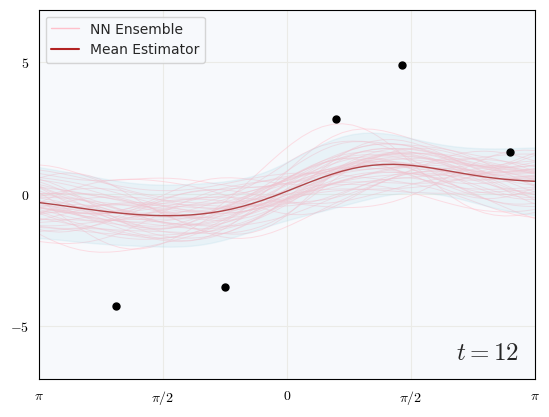

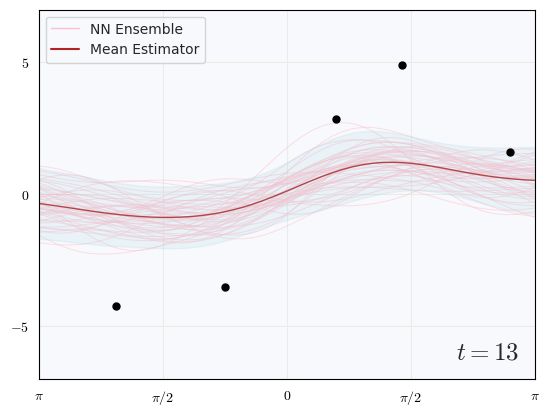

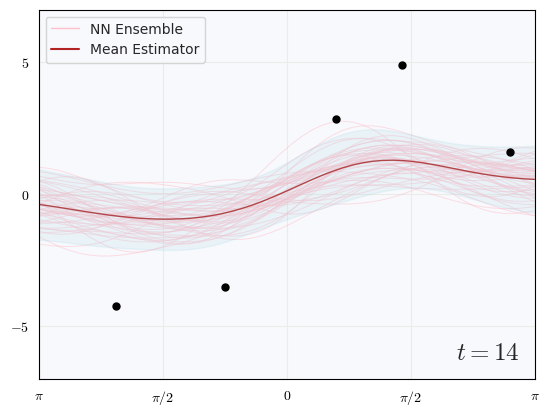

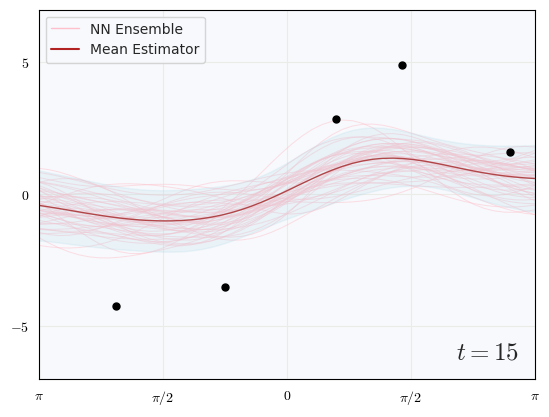

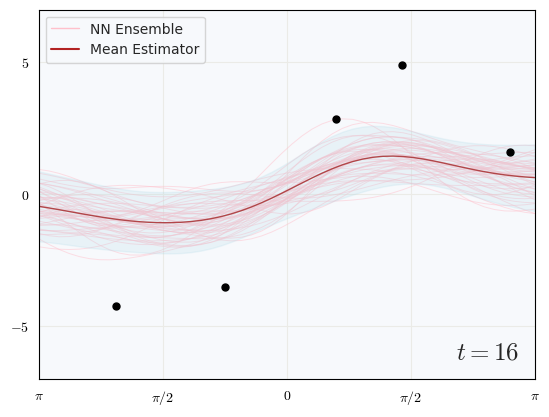

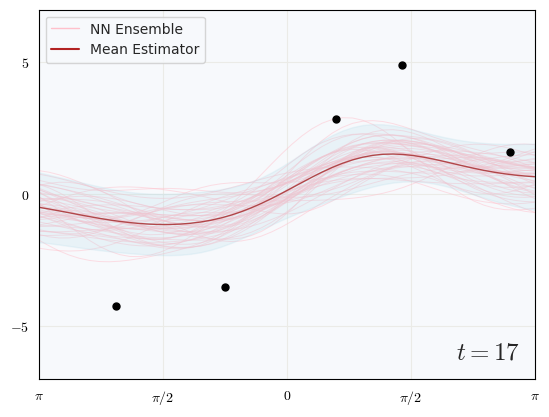

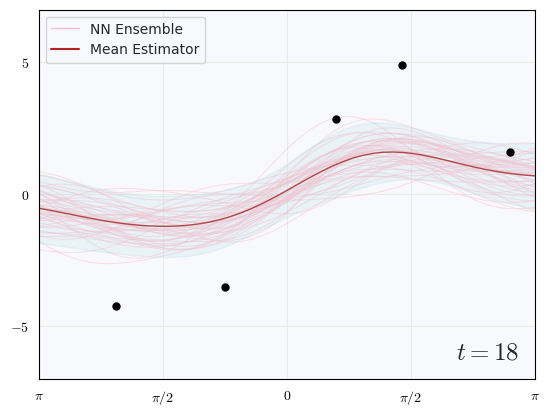

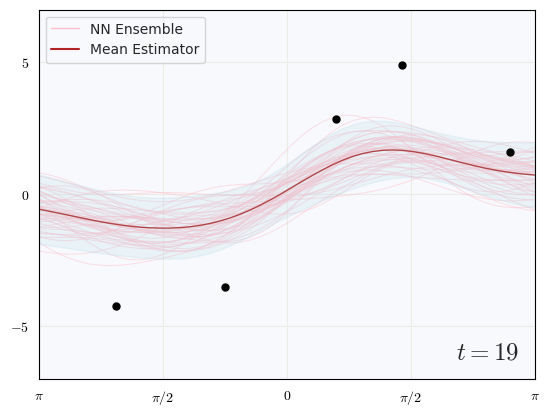

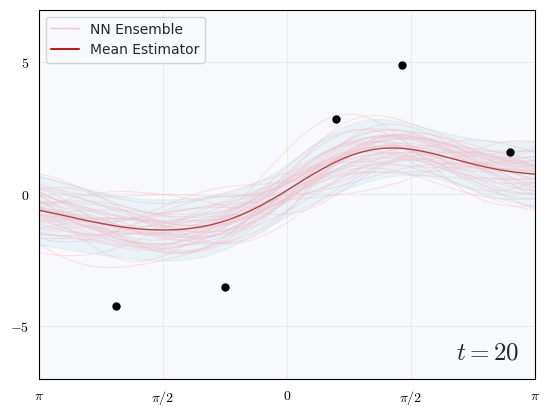

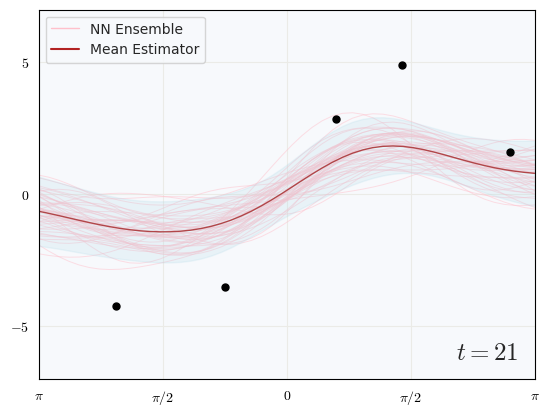

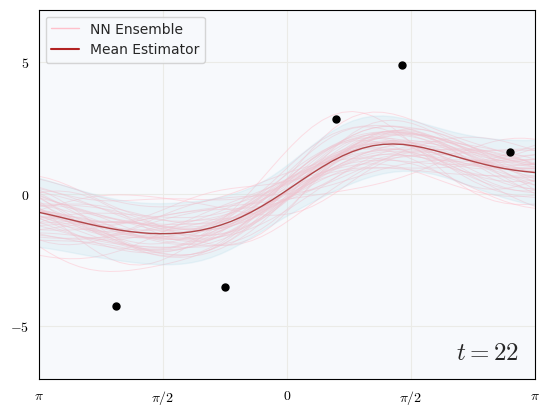

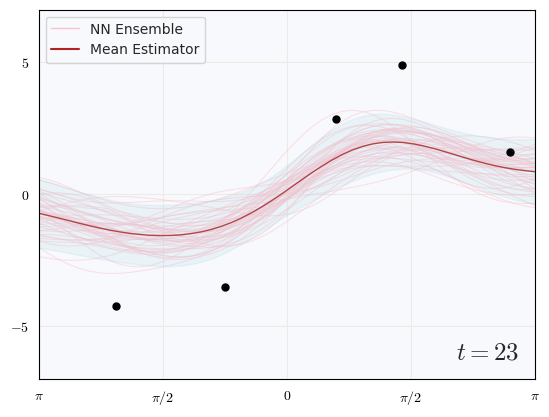

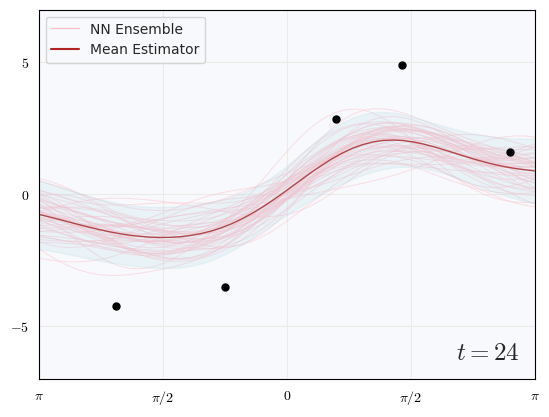

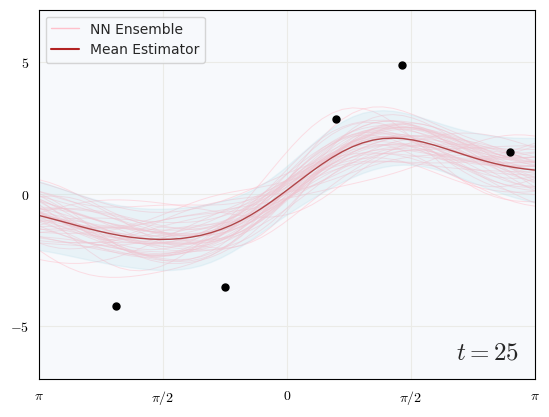

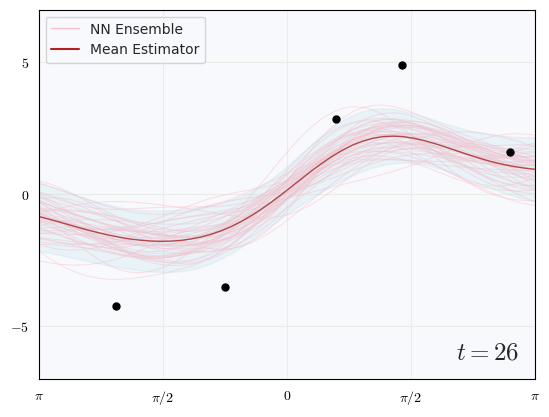

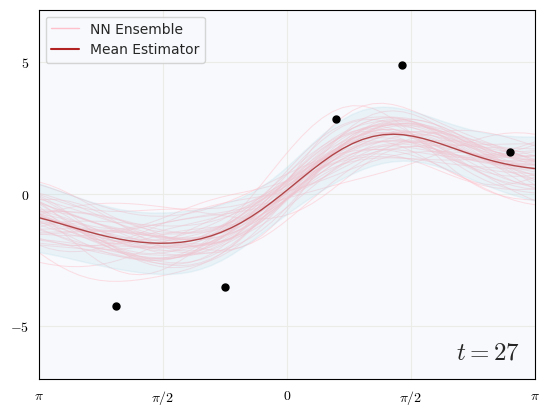

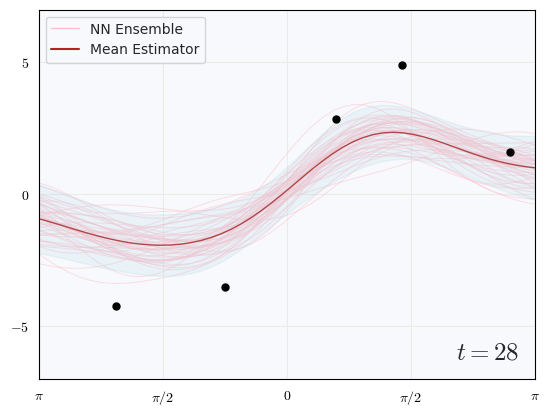

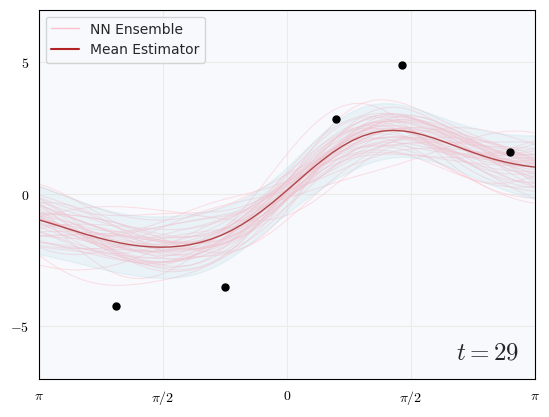

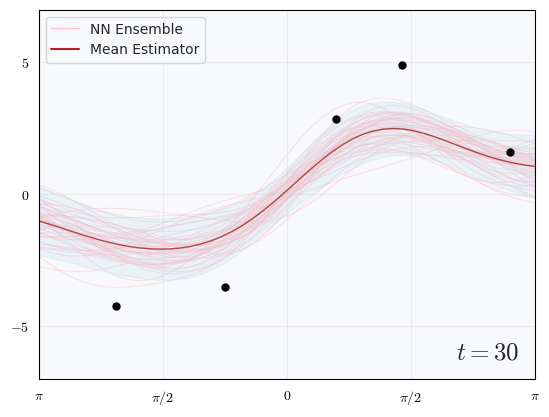

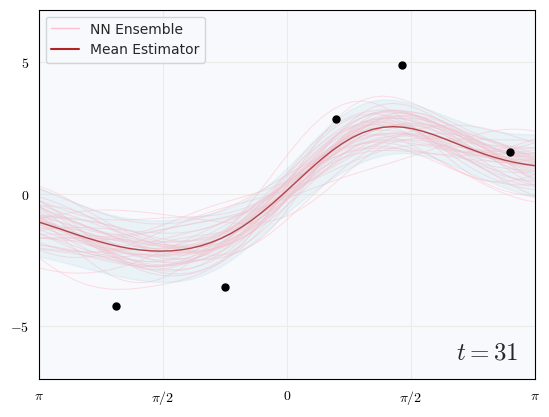

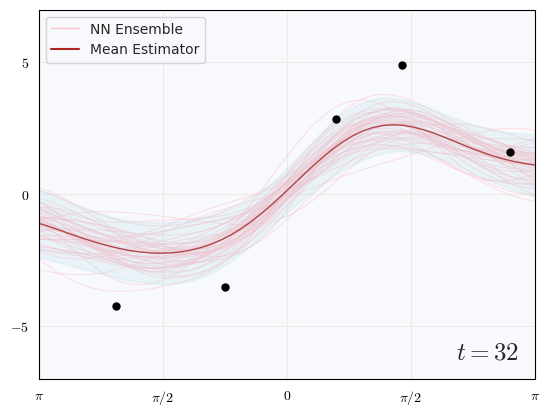

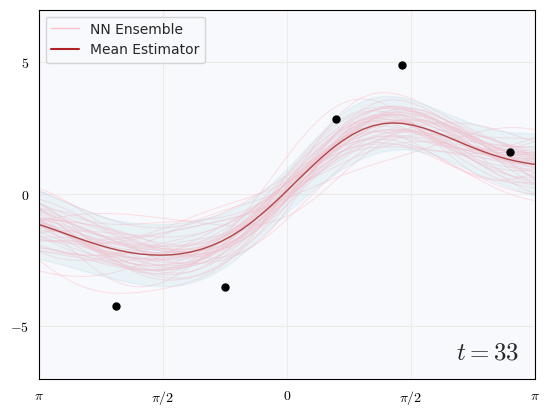

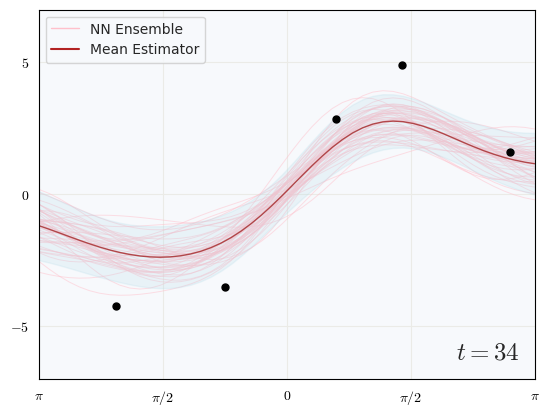

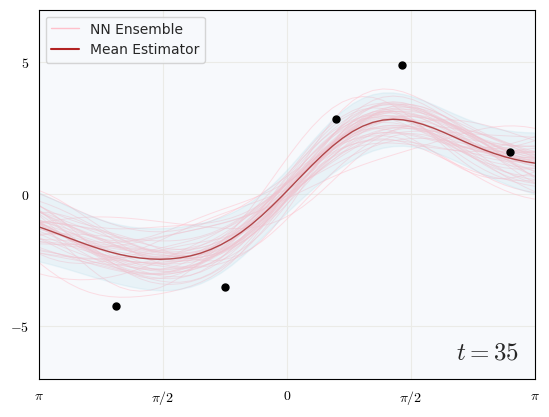

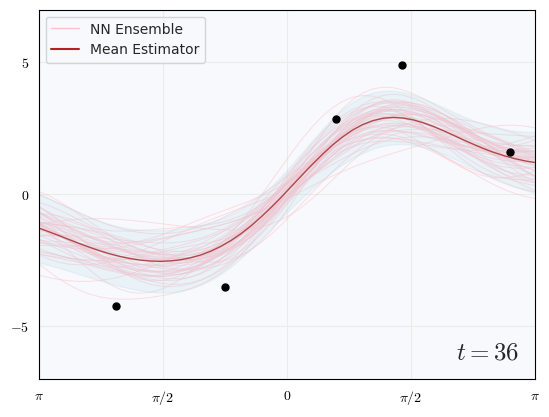

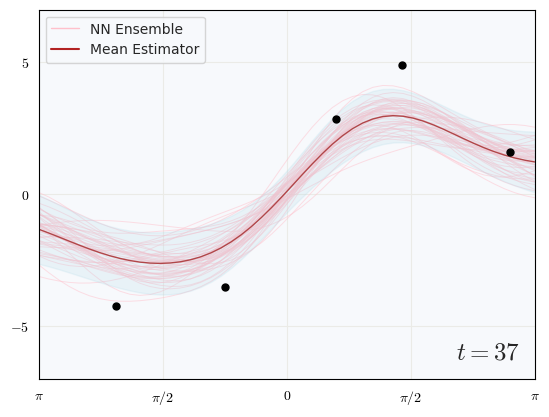

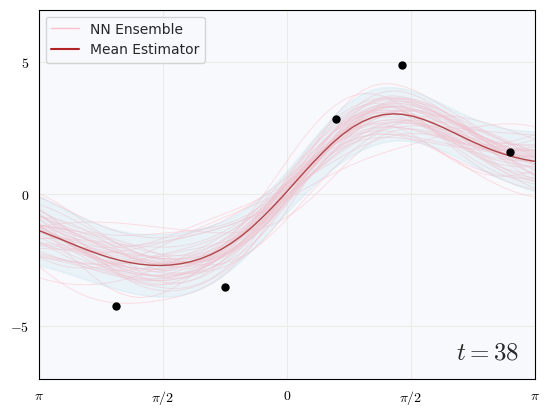

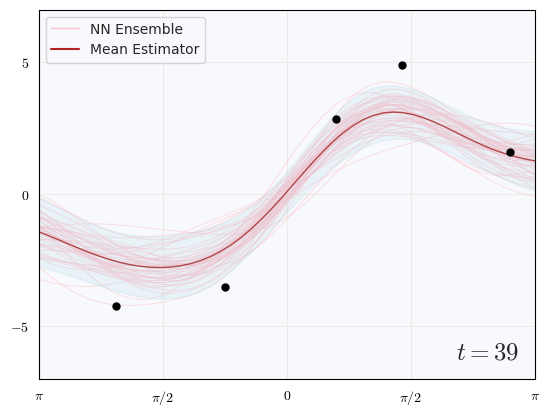

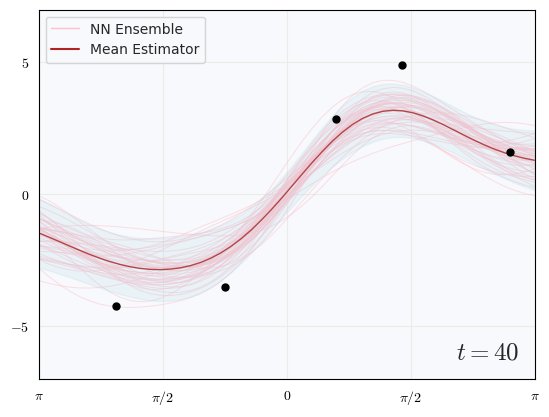

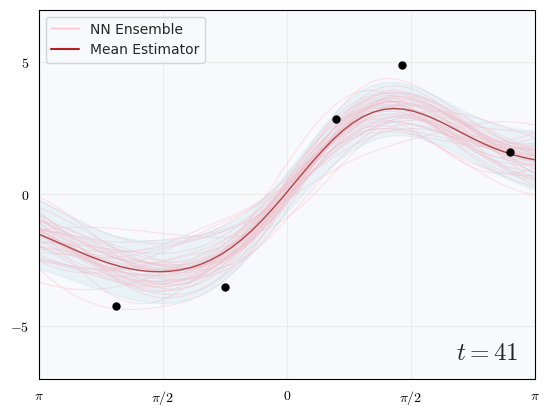

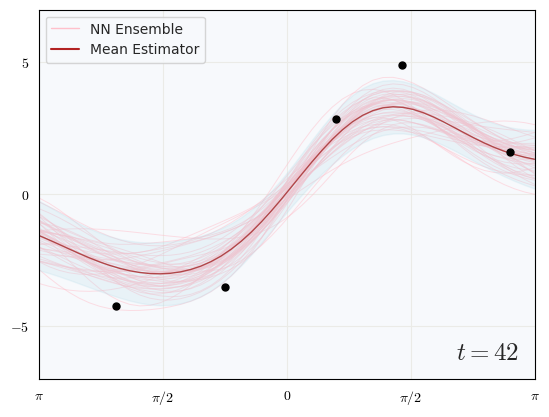

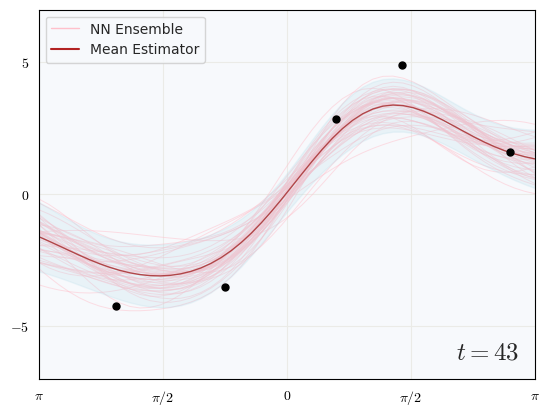

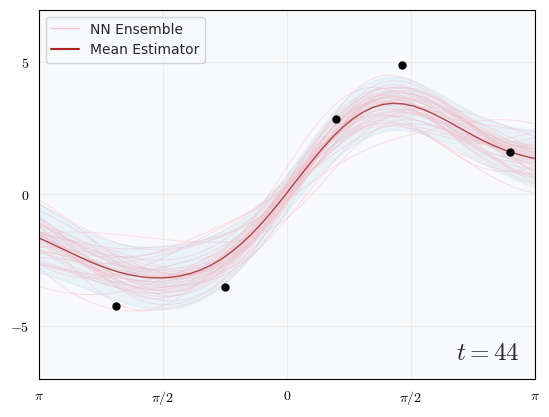

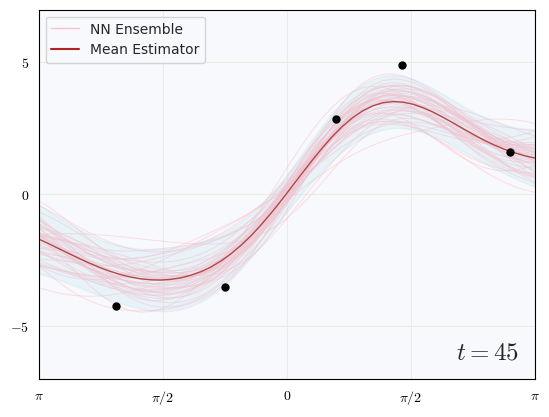

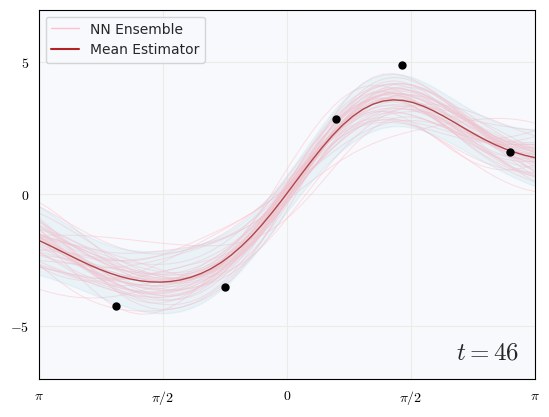

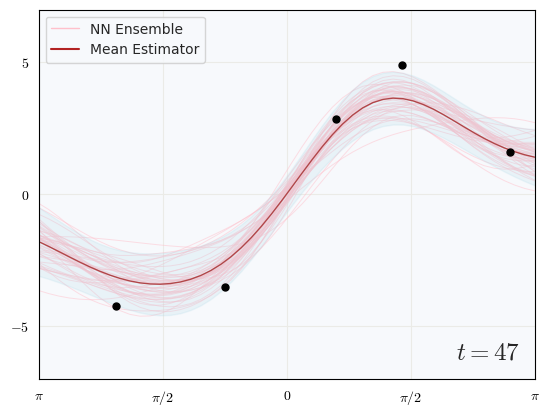

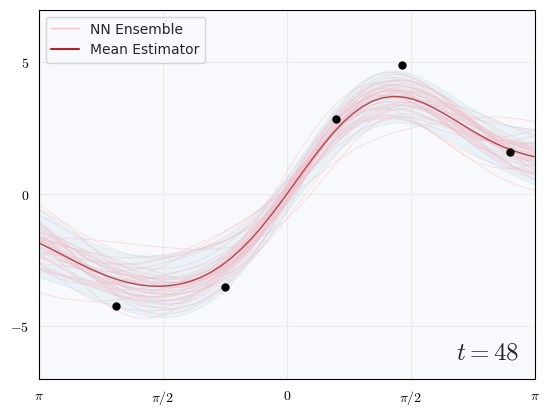

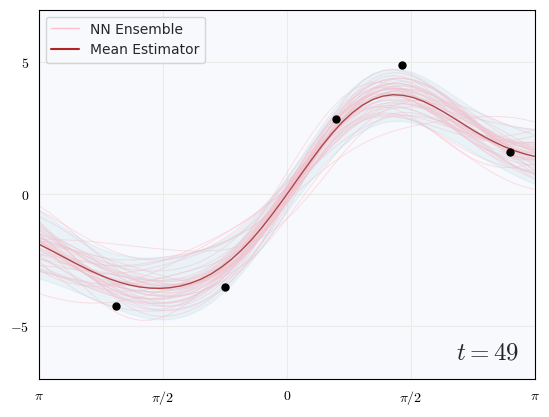

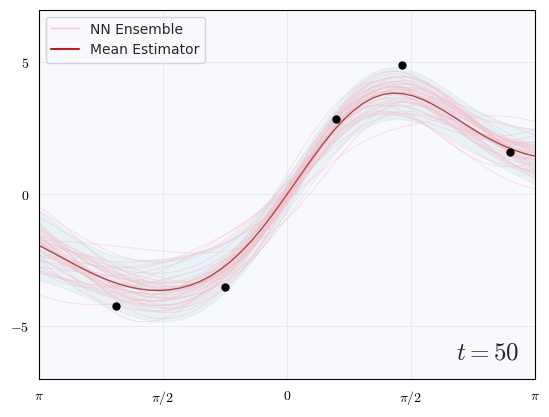

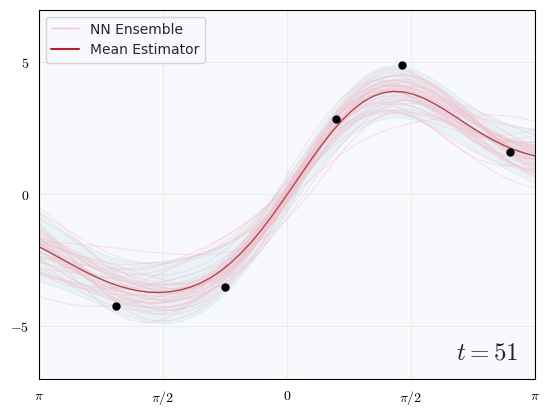

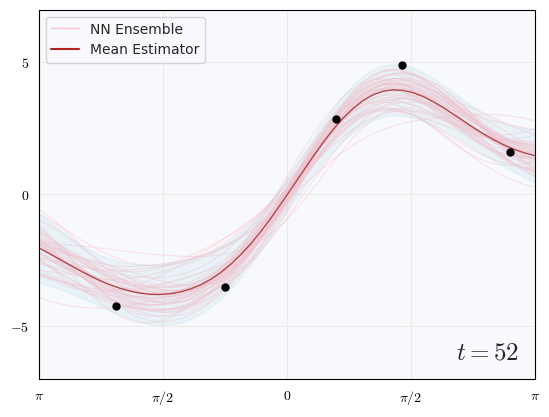

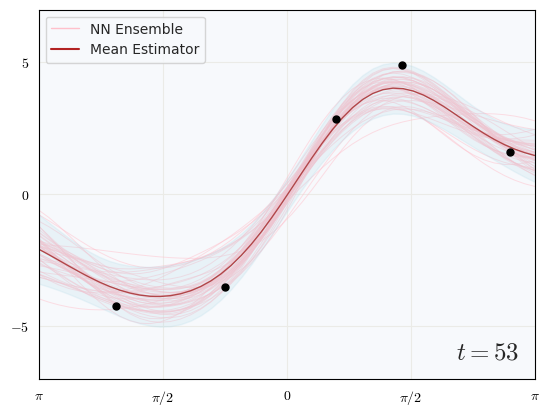

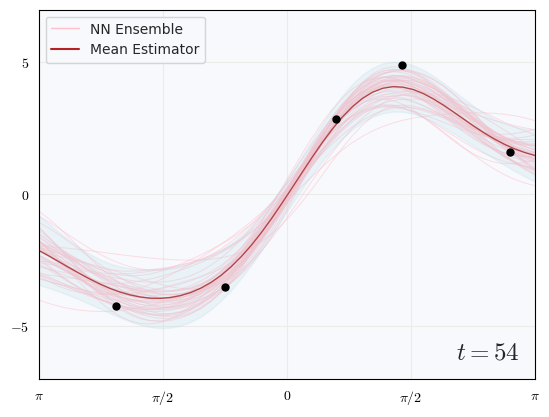

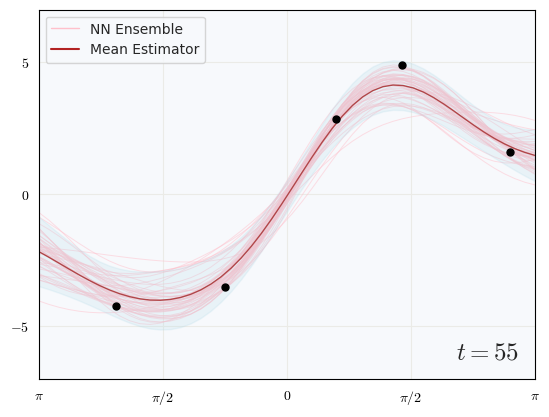

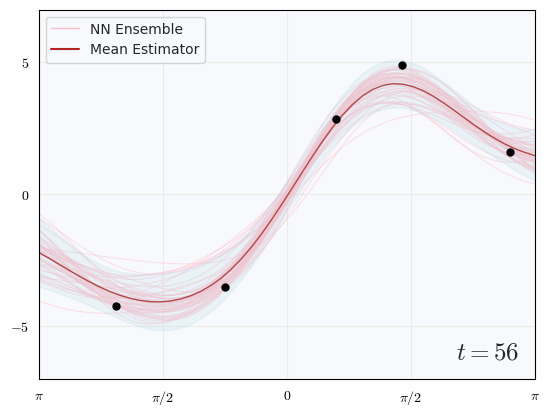

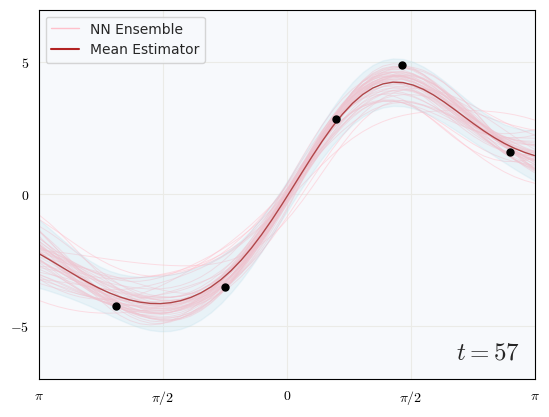

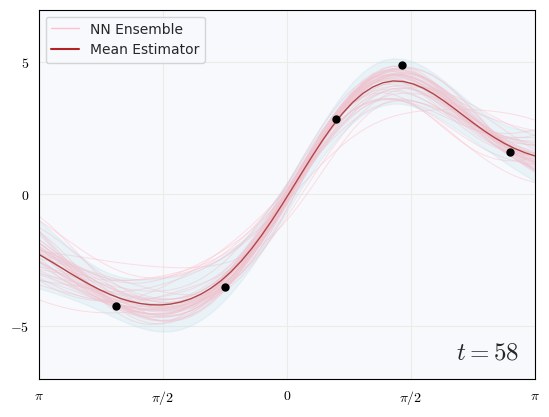

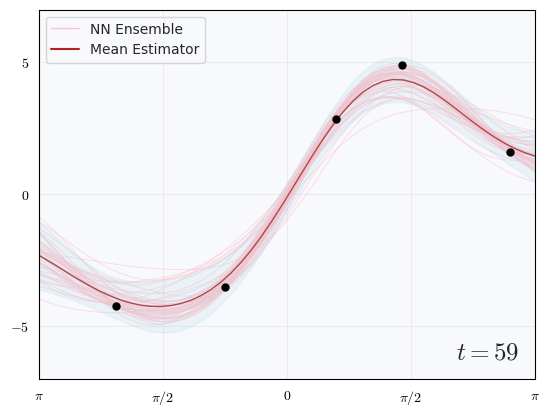

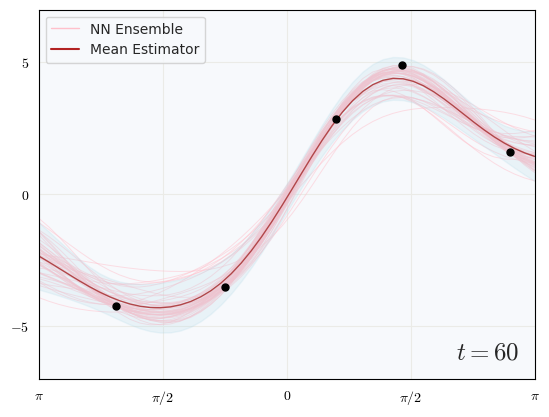

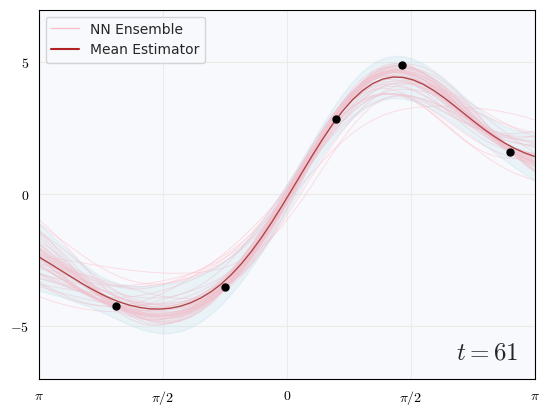

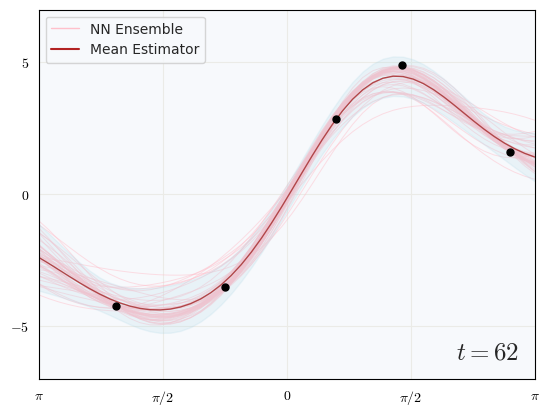

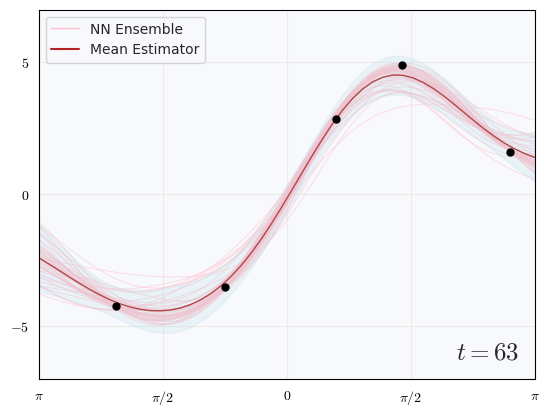

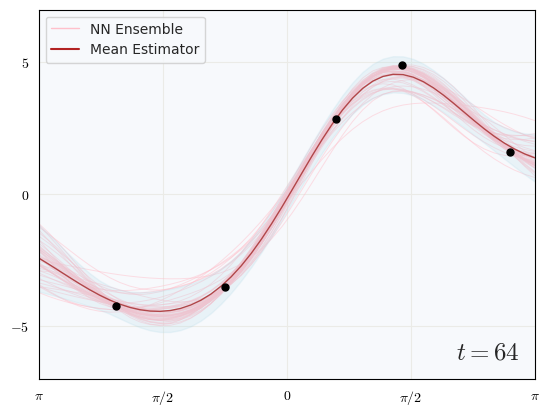

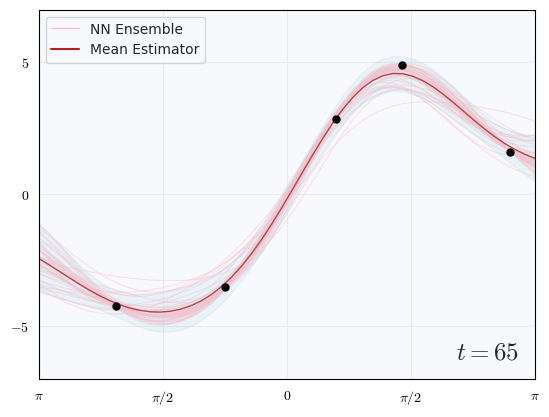

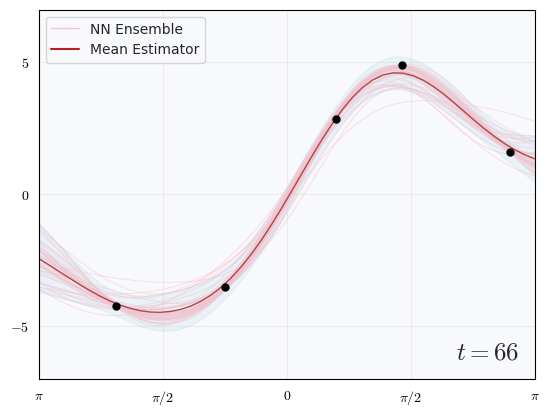

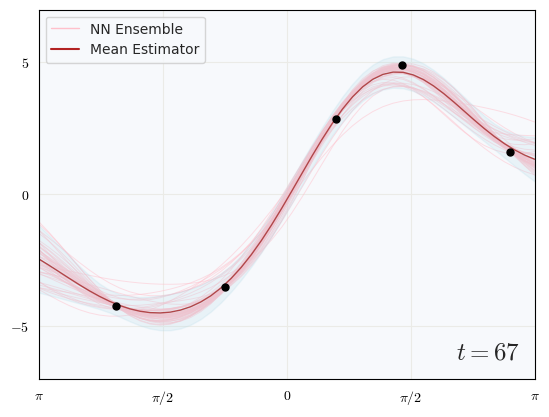

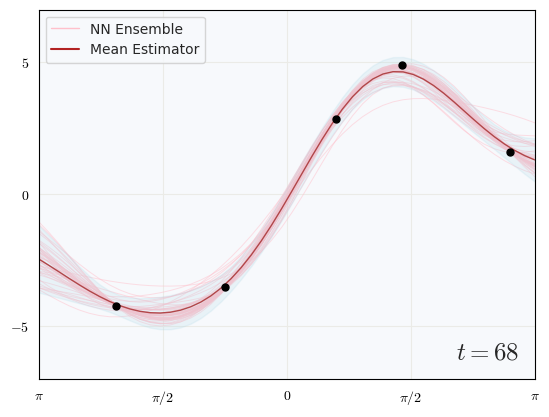

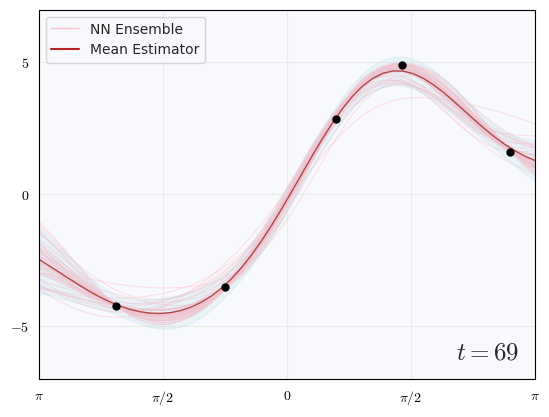

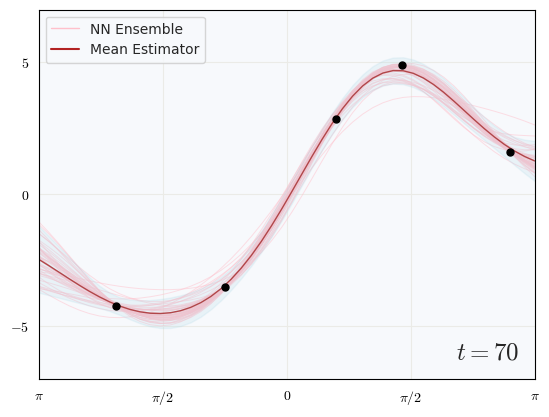

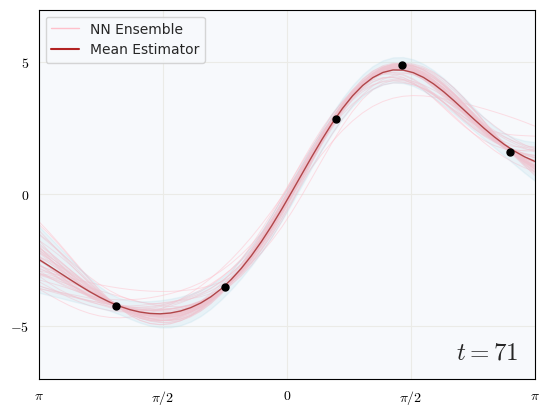

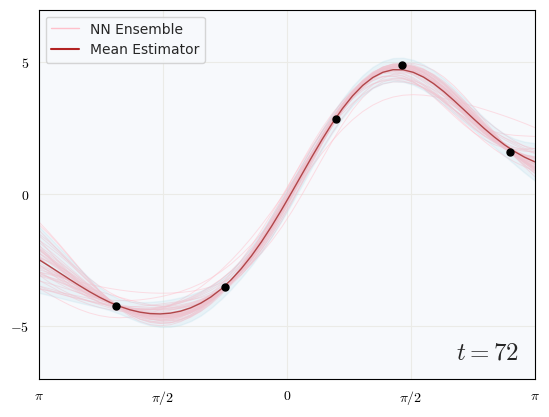

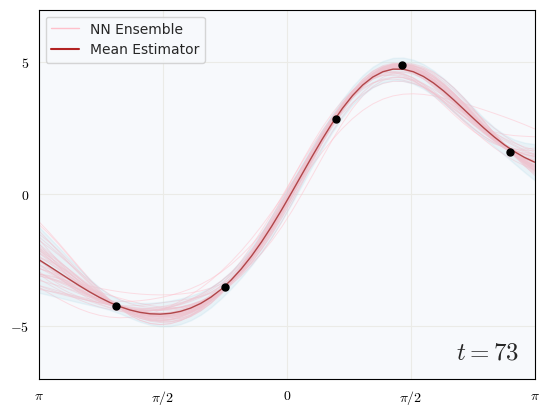

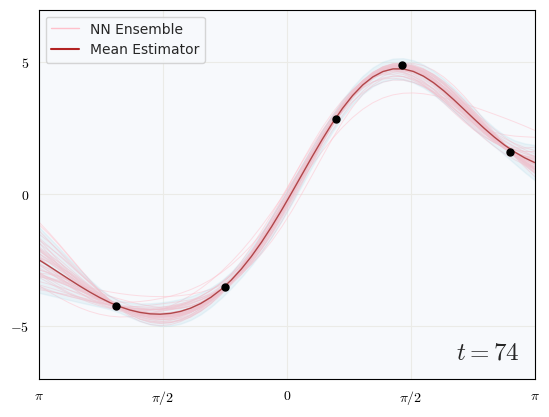

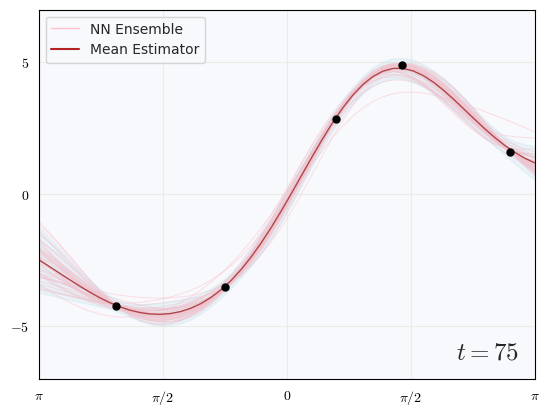

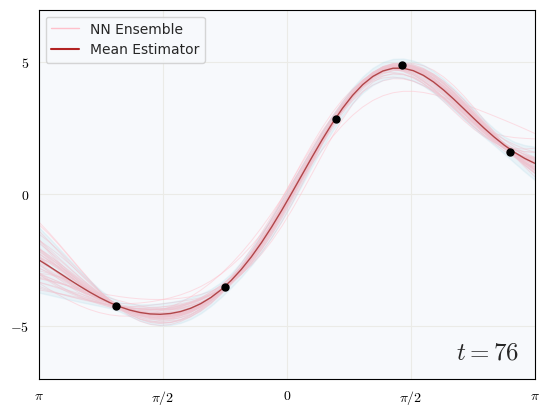

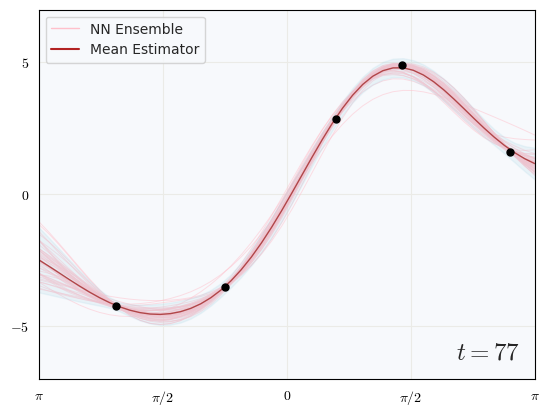

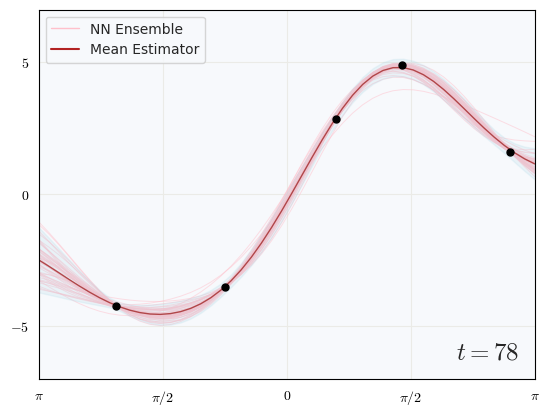

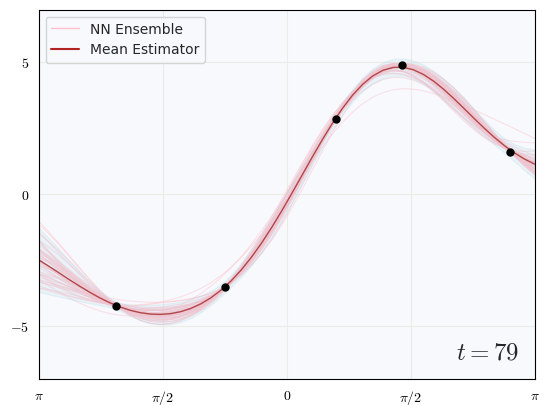

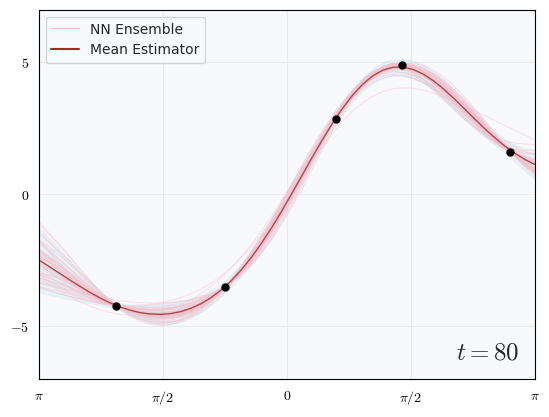

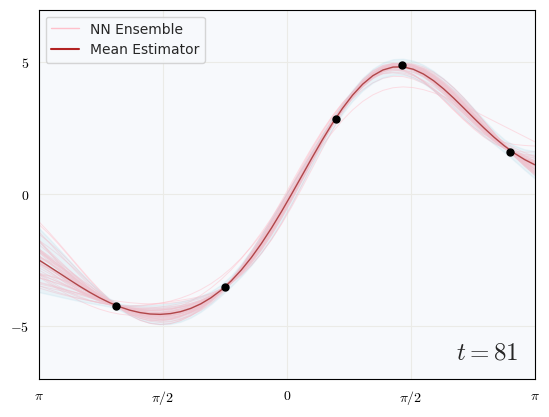

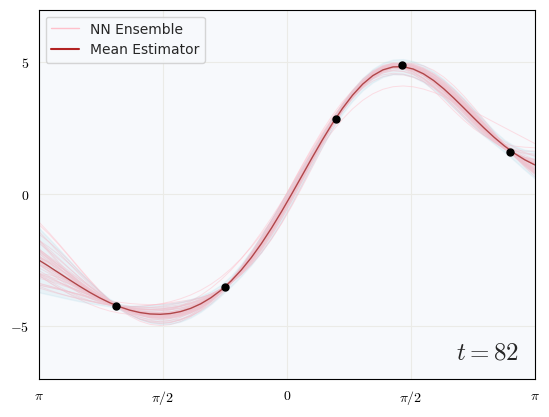

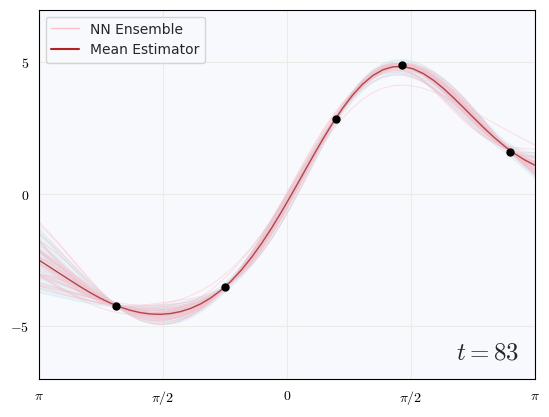

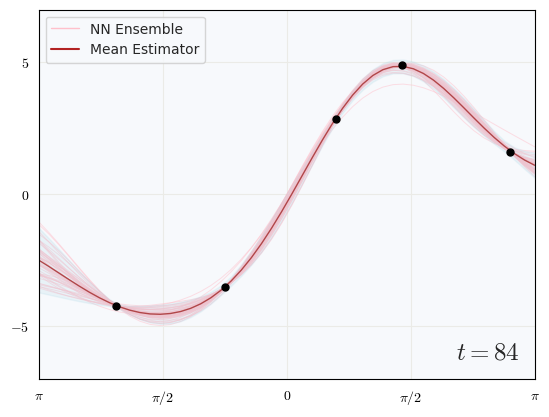

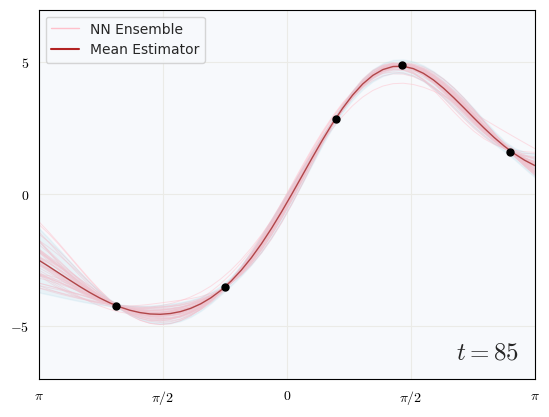

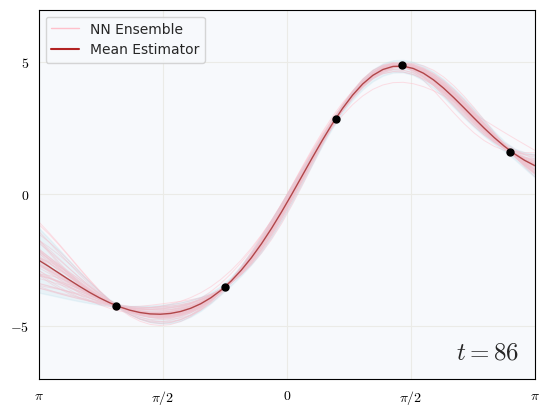

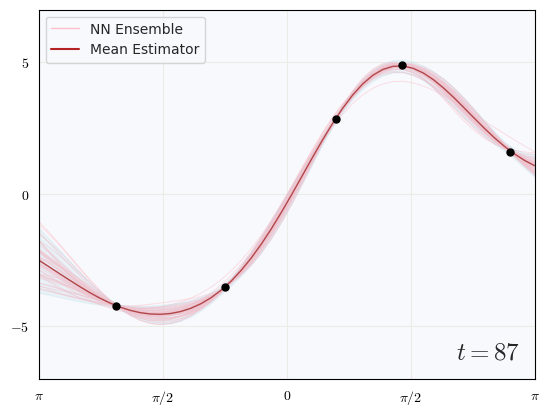

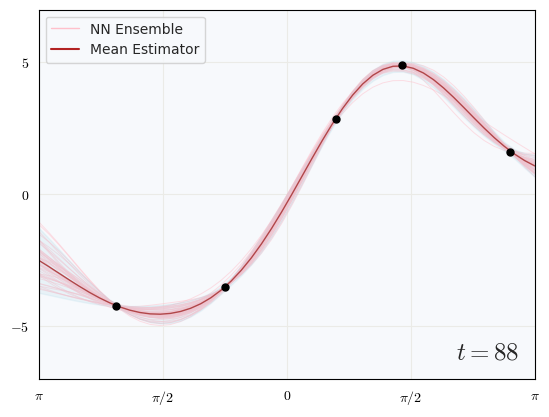

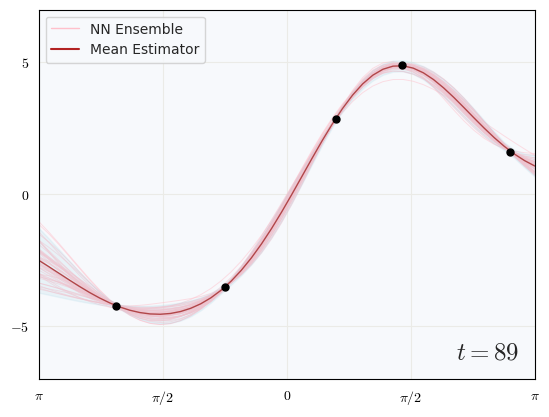

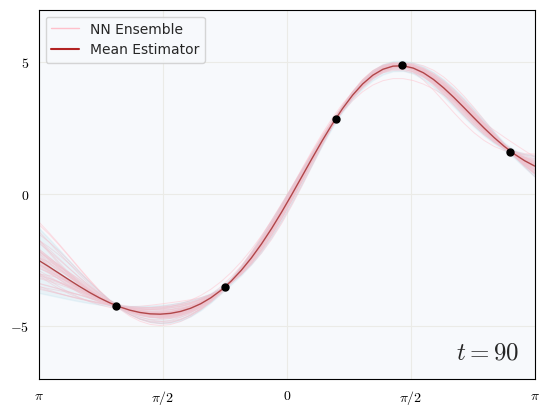

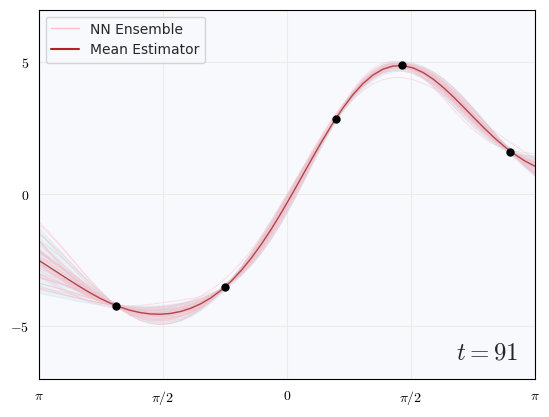

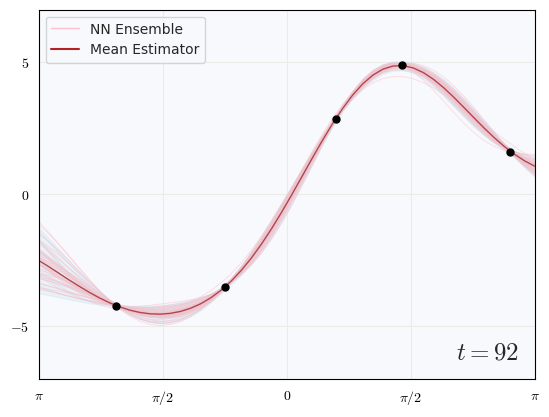

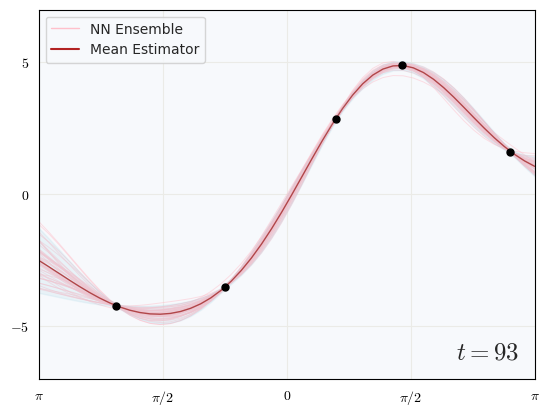

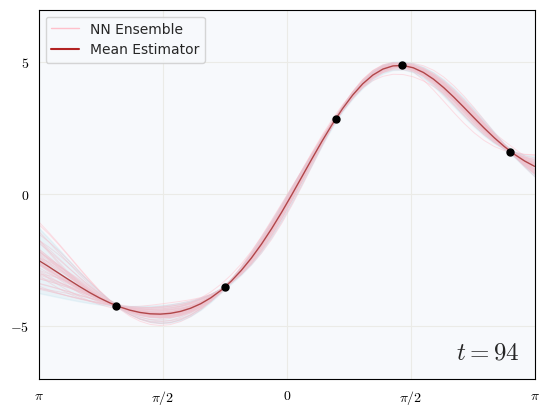

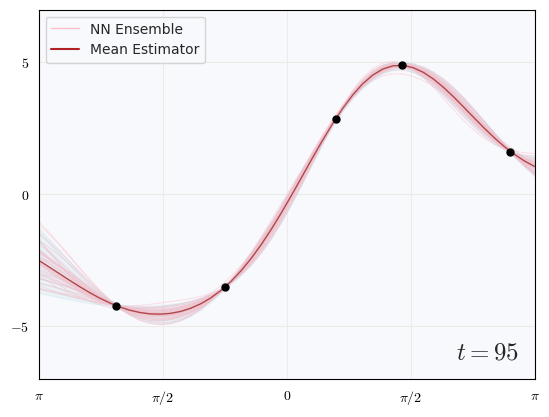

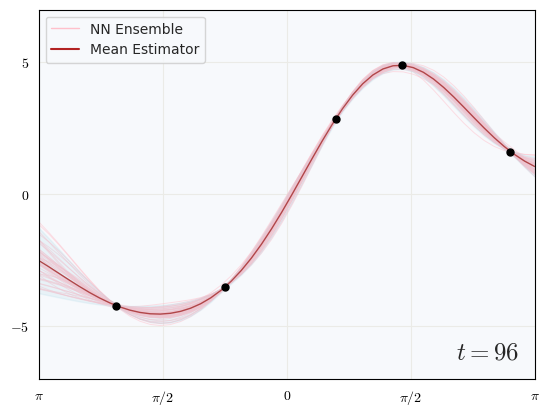

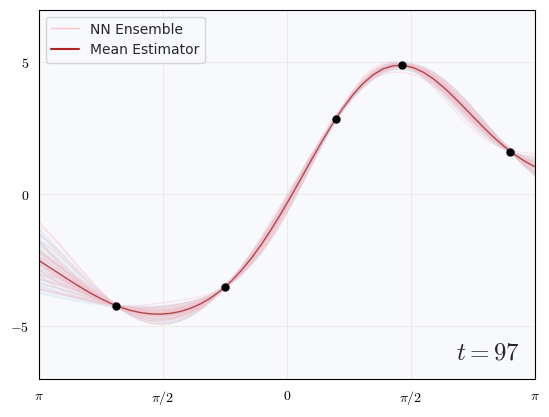

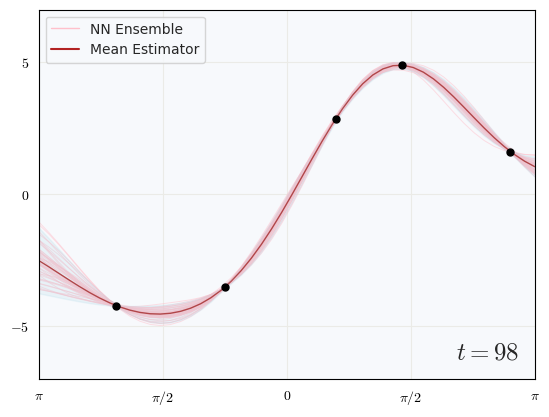

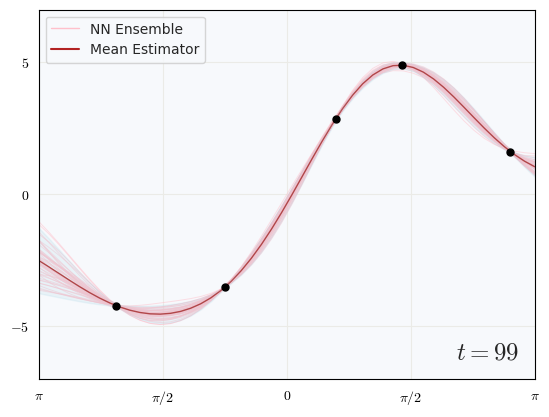

In [49]:
for epoch in range(100):

  fig = plt.figure()

  plt.rcParams.update({
    "mathtext.fontset": "cm",
    "font.family": "sans-serif",
    "text.usetex": False,
  })

  preds = []

  for nn in nn_ensemble[0:]:

    pred = nn(x_test)

    preds.append(pred)

    plt.plot(x_test, pred, c='pink', lw=.7, alpha=.5, label='NN Ensemble', zorder=1)

    nn.train_step(x_train, y_train, optimizer=Adam(learning_rate=.0006), loss_fn=MeanSquaredError())

  mean = np.mean(preds, axis=0).reshape(50)
  std = np.std(preds, axis=0).reshape(50)

  plt.plot(x_test, mean, c='firebrick', lw=1, label='NN Ensemble Mean', zorder=1)
  plt.scatter(x_train, y_train, c='k', s=25, zorder=2)

  plt.fill_between(x_test,
                 mean - 2 * std,
                 mean +  2 * std,
                 color='lightblue', alpha=0.2, zorder=1);

  plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
             ['$\pi$', '$\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
  plt.yticks([-5, 0, 5], ['$-5$', '$0$', '$5$'])

  # plt.xlabel("$x$")
  # plt.ylabel("$y$")

  plt.xlim(-np.pi, np.pi)
  plt.ylim(-7, 7)

  plt.text(2.15, -6.25, f'$t = {epoch}$', {"fontsize":18})

  pink_line = Line2D([], [], color='pink', lw=1, label='NN Ensemble')
  blue_line = Line2D([], [], c='firebrick', lw=1.5, label='Mean Estimator')
  plt.legend(handles=[pink_line, blue_line], loc='upper left')

  plt.savefig(f"/content/gdrive/MyDrive/gradient_descent/t{epoch:02d}")